# Variational Sparse Gaussian Process Classification (白色化あり)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

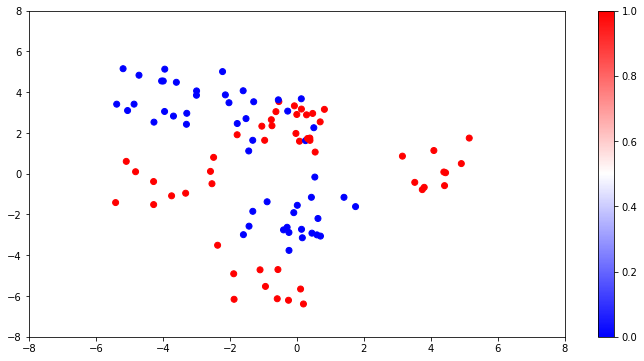

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
Z = X[:20, :].clone()
estimator = VSGP(Z, 1, kernel, likelihood, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_steps = 1000
for step in range(n_steps):
    loss = svi.step(X, y)
    if step % (n_steps / 10) == 0:
        print(loss)

85.60270211830453
57.41189391378991
52.525845102730926
50.29697270567205
48.04524043322399
46.51244388123948
50.20744747417278
48.030552869539235
48.21059699959925
50.348747156184245


---

## 推論結果

### 予測分布

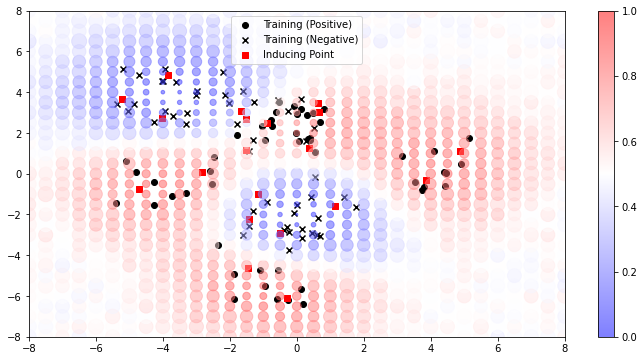

CPU times: user 20.6 s, sys: 841 ms, total: 21.5 s
Wall time: 5.86 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    s = ((pnew_std - pnew_std[:, 0].min()) / pnew_std[:, 0].std() + 0.1) * 50
    plt.figure(figsize = (12, 6))
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.scatter(x = Xnew[:, 0], y = Xnew[:, 1], c = pnew_mean[:, 0], s = s, marker = "o", cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.colorbar()
    plt.legend()
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.7029, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.Z

Parameter containing:
tensor([[-0.8816,  2.4893],
        [-5.2235,  3.6532],
        [ 4.8815,  1.1149],
        [-1.5154,  1.1871],
        [-2.8326,  0.0962],
        [-4.0283,  2.7321],
        [-1.4483, -4.6372],
        [-1.1524, -1.0152],
        [ 0.6743,  3.0271],
        [-1.4408, -2.2077],
        [ 0.6196,  3.4680],
        [-3.8590,  4.8637],
        [ 3.8522, -0.3281],
        [-1.6700,  3.0742],
        [-4.6980, -0.7487],
        [-1.5068,  2.6847],
        [-0.2784, -6.0904],
        [ 1.1480, -1.5819],
        [ 0.3544,  1.2710],
        [-0.5101, -2.8966]], requires_grad=True)

In [12]:
estimator.u_loc

Parameter containing:
tensor([[ 0.4072, -1.6649,  1.3491,  0.2036,  1.1976, -1.0429,  0.8501, -2.0435,
          1.1464, -0.6782, -0.8295, -1.1991,  0.6290, -0.9110,  0.6840,  0.0774,
          1.0537, -1.4560,  0.3238, -1.0044]], requires_grad=True)

In [13]:
estimator.u_cov

tensor([[[ 1.9866e-01, -1.6648e-02, -4.3468e-02, -1.1507e-02, -4.3260e-02,
          -7.1981e-03,  1.0880e-02,  6.9445e-03, -1.1984e-01,  6.4454e-03,
          -8.2573e-03, -1.8040e-02, -4.7960e-03, -6.5563e-02,  4.0730e-03,
          -2.1340e-03,  1.6040e-02,  1.6774e-02, -4.4705e-02,  3.9406e-02],
         [-1.6648e-02,  7.3399e-01, -2.4552e-02, -8.9547e-02, -3.0358e-02,
          -1.3518e-01, -1.0634e-01, -9.0575e-03,  3.1508e-02,  5.1568e-02,
          -4.7579e-02, -9.6137e-02, -9.0013e-02,  3.4048e-02, -5.4453e-02,
           1.6759e-02, -6.0391e-02, -1.2874e-01,  6.0895e-03, -1.0214e-02],
         [-4.3468e-02, -2.4552e-02,  5.7536e-01,  1.4833e-01, -4.0954e-02,
           1.2107e-02,  7.2690e-03,  6.2142e-02,  4.6011e-02, -2.2052e-03,
           9.6593e-02, -4.9736e-02, -1.0656e-01, -3.9923e-02,  4.1482e-02,
           1.0813e-02,  3.5142e-02,  3.6413e-02, -9.8503e-02,  4.2017e-02],
         [-1.1507e-02, -8.9547e-02,  1.4833e-01,  6.2377e-01, -1.3350e-01,
          -5.4112e-02,